
Success! The measured string matches the secret string.
Measured bitstring (should be 0):
{'0': 1024}

Success! The measured string matches the secret string.
Measured bitstring (should be 11):
{'11': 1024}

Success! The measured string matches the secret string.
Measured bitstring (should be 001):
{'001': 1024}

Success! The measured string matches the secret string.
Measured bitstring (should be 1110):
{'1110': 1024}

Success! The measured string matches the secret string.
Measured bitstring (should be 10100):
{'10100': 1024}

Success! The measured string matches the secret string.
Measured bitstring (should be 110110):
{'110110': 1024}

Success! The measured string matches the secret string.
Measured bitstring (should be 1001101):
{'1001101': 1024}

Success! The measured string matches the secret string.
Measured bitstring (should be 00110100):
{'00110100': 1024}

Success! The measured string matches the secret string.
Measured bitstring (should be 100010010):
{'100010010': 1024}



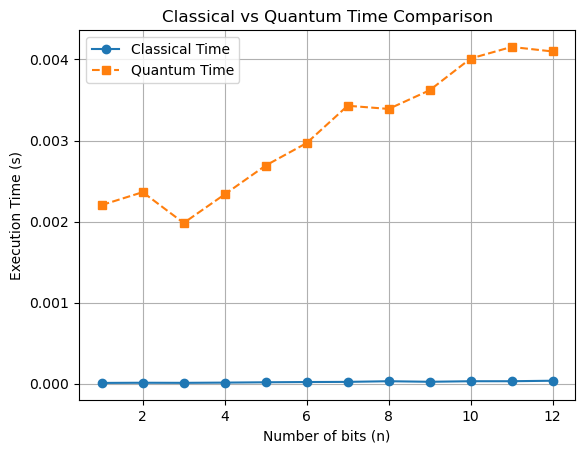

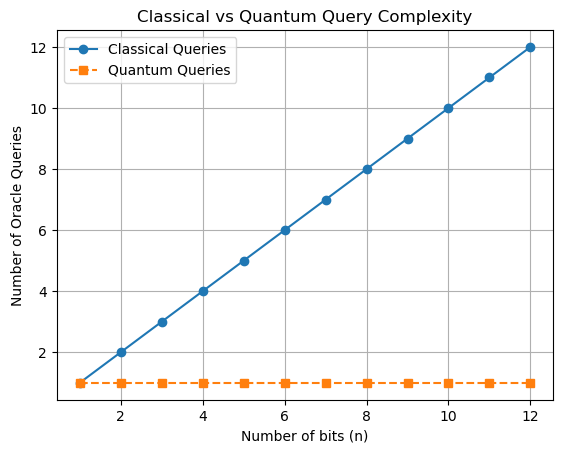

In [12]:
# Import Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import *
import matplotlib.pyplot as plt
import numpy as np
import time

# Classical oracle: f(x) = s·x mod 2
def classical_oracle(s, x):
    return sum([int(si) & int(xi) for si, xi in zip(s, x)]) % 2

def classical_strategy(s):
    n = len(s)
    recovered = ''
    for i in range(n):
        x = ['0'] * n
        x[i] = '1'
        fx = classical_oracle(s, x)
        recovered += str(fx)
    return recovered

# Function to implement the Bernstein-Vazirani circuit
def bernstein_vazirani(s: str):
    n = len(s)  # Number of qubits

    # Step 1: Initialize registers
    # We need n qubits for the input register and one ancillary qubit for the oracle.
    # We also need n classical bits to store the measurement results.
    # The qubits are automatically initialized to the state |0⟩.
    
    qc = QuantumCircuit(n + 1, n)

    # Step 2 To create the phase oracle, we need the ancillary qubit in the state |−⟩.
    # We achieve this by applying an X gate (to make it |1⟩) followed by a Hadamard gate.
    qc.x(n)
    qc.h(n)
    qc.barrier() # Add a barrier for visual clarity
    # Apply Hadamard gates to all input qubits
    # This puts the input register into a superposition of all possible states.
    qc.h(range(n))
    
    qc.barrier() # Add a barrier for visual clarity
    
   # Step 3: Apply the phase oracle U_f
    # The oracle flips the phase of the states |x⟩ based on the secret string 's'.
    # It applies a CNOT for each '1' in the secret_string.
    # The i-th qubit is the control and the ancillary qubit is the target.
    # We iterate through the secret string in reverse because Qiskit orders qubits from right to left (q0, q1, ...).
    for i, bit in enumerate(reversed(s)):
        if bit == '1':
            qc.cx(i, n) # Apply CNOT from data qubit i to the ancilla

    qc.barrier() # for visual separation

    # Step 4: Apply Hadamard gates again to the input qubits
    # This interferes the states to isolate the secret string 's'.
    qc.h(range(n))

    # Step 5: Measure the first n qubits
    # Measure the first n qubits
    qc.measure(range(n), range(n))

    return qc


# Quantum BV algorithm with phase oracle
def quantum_bv_circuit(s):
    qc = bernstein_vazirani(s)

    # Simulate the circuit
    simulator = Aer.get_backend('aer_simulator')
    job = simulator.run(qc, shots=1024)
    result = job.result()
    #compiled_circuit = transpile(qc, simulator)
    #result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts()

    # Find the most frequent outcome
    measured_string = max(counts, key=counts.get)
    if measured_string == s:
        print("\nSuccess! The measured string matches the secret string.")
    else:
        print("\nFailure! The measured string does not match.")

    # Display results
    print(f"Measured bitstring (should be {s}):")
    print(counts)

    return measured_string

# Benchmarking loop/ Run timing tests
max_n = 12
results = []

for n in range(1, max_n + 1):
    s = ''.join(np.random.choice(['0', '1'], size=n))

    start_classical = time.time()
    _ = classical_strategy(s)
    classical_time = time.time() - start_classical

    start_quantum = time.time()
    _ = quantum_bv_circuit(s)
    quantum_time = time.time() - start_quantum

    results.append({
        'n': n,
        'classical_time': classical_time,
        'quantum_time': quantum_time,
        'classical_queries': n,
        'quantum_queries': 1
    })

# Display results
print(f"results from benchmark/time test (should be {results}):")
    
# Plotting time performance
ns = [r['n'] for r in results]
ct = [r['classical_time'] for r in results]
qt = [r['quantum_time'] for r in results]

plt.plot(ns, ct, 'o-', label='Classical Time')
plt.plot(ns, qt, 's--', label='Quantum Time')
plt.xlabel("Number of bits (n)")
plt.ylabel("Execution Time (s)")
plt.title("Classical vs Quantum Time Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Plotting queries
cq = [r['classical_queries'] for r in results]
qq = [r['quantum_queries'] for r in results]

plt.plot(ns, cq, 'o-', label='Classical Queries')
plt.plot(ns, qq, 's--', label='Quantum Queries')
plt.xlabel("Number of bits (n)")
plt.ylabel("Number of Oracle Queries")
plt.title("Classical vs Quantum Query Complexity")
plt.legend()
plt.grid(True)
plt.show()

